In [ ]:
# author: Sorush mortazavi
# std_id: 9631068

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import copy
import keras
from keras import layers
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
import time
 

In [ ]:
def board_init():
  """
  creates and returns the initail game board state
  a 2D matrix consisting of 16 rows, each having 4 columns
  of zero at first
  """
  board = np.zeros((16, 4))
  
  return board
 
def win_trails():
  """
  returns a list of positions in which a win trail can be formed.
  """
  # all possible win trails
  trails = [ range(0, 4), range(4, 8), range(8, 12), range(12,16), # horizental
              range(0, 16, 4), range(1, 16, 4), range(2, 16, 4), range(3, 16, 4), # vertical
              range(0, 16, 5), range(3, 15, 3) ] # digonal
  return trails
 
def decode_state(state):
  """
  decodes the state to show who has occupied which cell of
  the borad. 1 means player1, -1 means player2, 0 means none
  """
  weights = np.array([1, 1.5, 2.25, 3.75])
 
  # black_white determines which place is currently occupied by which player
  # 1 means player1, -1 means player2, and zero means none
  black_white = np.matmul(state,weights)
  black_white = np.where(black_white>0, 1, black_white)
  black_white = np.where(black_white<0, -1, black_white)
 
  return black_white
 
def G_V1(states, model=None):
  """
  returns the G_V1 value function (approximation) of the input state.
  """
  values = []
  filters = win_trails()
  for state in states:
    black_white = decode_state(state)
  
    # apply the filters above on black_white to determine the value function
    # of the current state
    value = 0
    for f in filters:
      
      num_whites = (black_white[f]==1).sum()
      num_blacks = (black_white[f]==-1).sum()
  
      curr_value = num_whites * np.exp(num_whites*2.1)
      curr_value -= num_blacks * np.exp(num_blacks*2.1)
      curr_value -= (num_blacks-num_whites) * np.exp((num_blacks-num_whites)*2.5)
      curr_value += np.max(state, 1).sum()
  
      # just accumulate the values
      value += curr_value
  
    value = np.where(value>0, 1, -1) * np.log(abs(value))
    values.append(value)
  return np.array(values)
 
def G_CV(states, model):
  """
  returns the G_CV value function (approximation) of the input states.
  """
  # board_featuers = decode_state(states).reshape(1, 16)
  if len(np.shape(states))>2:
    return model.predict_on_batch(states)

  return model(states.reshape(1,16,4), training=False )[0][0]
 
def possible_moves(curr_state, deck, value_func, model=None, with_values=True, two_way=False):
  """
  explores all avilable moves and their resulting states, value functions
  returns a list of states to which we'll arrive given a particular action.
  inputs:
  curr_state: current state of the game.
  deck: player's current deck in game.
  value_func: the function to calculate the value of a given state.
 
  returns: the next (states, deck) and corresponding values
  """
  # t = time.time()
  # we explore all available actions and select the action
  # which will produce the best next state.
  values = []
  states = []
  
  # filters are all the possible win trails
  filters = win_trails()
 
  # black_white determines which place is currently occupied by which player
  # 1 means player1, -1 means player2, and zero means none
  black_white = decode_state(curr_state)
 
  # print(black_white.reshape(4,4))
  # first explore actions starting from the deck.
  seen = []
  # print("1:", time.time()-t)
  # t = time.time()
  for g in range(len(deck)):
        group = deck[g]
        if len(group)<1:
          continue
        piece = group.pop()
        if piece in seen:
          group.append(piece)
          continue
        seen.append(piece)
        for cell in curr_state:
            
            
            if max(abs(cell))==0: # empty cell, can put any piece here
              cell[0] = piece
              states.append([curr_state.copy(), copy.deepcopy(deck)])
              cell[0] = 0 # undo the state after appending the action

        # only if the player is about to lose, he/she can place the chosen
        # piece on an opponent's piece, keeping him/her from winning.
        for f in filters:
          if (black_white[f]==-1).sum()>2: # opponent might be winning
            for p in f:
              cell = curr_state[p]
              if max(abs(cell))==0:
                continue
              if cell[cell != 0][-1] < 0 and abs(cell[cell != 0][-1]) < piece:
              # meaning the top piece isn't the player's and it is not bigger than our piece
                cell_back_up = cell[(cell != 0).sum()]
                cell[(cell != 0).sum()] = piece
                states.append([curr_state.copy(), copy.deepcopy(deck)])
                cell[(cell != 0).sum()-1] = cell_back_up # undo the state after appending the action
        group.append(piece)
  # print("2:", time.time()-t)
  # t = time.time()
  state_backup = curr_state.copy()
  # now to explore the within board moves.
  for i in range(len(curr_state)):
    cell = curr_state[i]
    if max(abs(cell))==0: 
      continue
    # meaning the cell isn't empty
    piece = cell[cell != 0][-1]
    if piece <= 0 :
      continue # meaning the top piece isn't the player's
    for j in range(len(curr_state)): # looking for all the places to put it
      cell = curr_state[j]
      if max(abs(cell)) < piece: # our piece is larger and can be placed
        curr_state[j][(cell != 0).sum()] = piece
        curr_state[i][(curr_state[i] != 0).sum()-1] = 0
        states.append([curr_state.copy(), copy.deepcopy(deck)])
        curr_state = state_backup.copy() # undo the state after appending the action

  # print("3:", time.time()-t)
  # t = time.time()
  if with_values:
    inputs = np.array([i[0] for i in states])
    values = value_func(inputs, model=model).flatten()
    if two_way:
      values += -value_func(-inputs, model=model).flatten()
  # print("4:", time.time()-t)
  return states, values
 
def next_state(curr_state, deck, value_func, model=None, turn=1, epsilon=0, two_way=False):
  """
  picks the next state based on current state and the value_func.
  epsilon is the percentage of randomness applied when choosing
  the next state according to their value function
  inputs:
  curr_state: current state of the game.
  deck: player's current deck in game.
  value_func: the function to calculate the value of a given state.
 
  returns: the next state as chosen by epsilon-greedy method.
  and the (changed/uchanged) deck of player
  """

  if turn!=1:
    curr_state = curr_state*-1

  # get all available moves and thier corresponding state value function
  states, values = possible_moves(curr_state, deck, value_func, model, two_way=two_way)
  # print(np.shape(states),np.shape(values))
  # for i in range(len(states)):
  #   print(decode_state(states[i][0]).reshape(4,4), values[i])
  #   print("_________")
  # return the best state and the corresponding deck
  if epsilon > np.random.rand(): # pick a random action
    rand_idx = np.random.randint(len(states))
    state, deck = states[rand_idx]
  else: # else, pick the best action
    state, deck = states[np.array(values).argmax()]
  if turn!=1:
    state = state*-1
  return state, deck
 
def initial_weights(shape):
  weights = []
  for l in shape:
    weights.append(np.random.random(l+1))
 
def delta_w(target_vlaue, est_value, weights, learning_method="monte_carlo"):
  if learning_method == "TD_0":
    # error = _lambda_ * player1_value_func(st, w)
    # it needs more work here
    pass
  else:
    error = target_vlaue - est_value
  dcost_dw = ...
  delta_w = alpha * error * dcost_dw
  w += delta_w # updating the parameters of value function approximator
 
def learn_game(player1_value_func=G_CV, player2_value_func=G_V1,
               learning_method="monte_carlo", num_episods=1000,
               alpha=0.01, _lambda_=0.02, weights=None, epsilon=0):
  """
  runs the learning algorithm for both player1 & player2, based on their
  value function (approximation) and the learning method used.
  returns: the learned parameters for player1_value_func.
  """

  history = [] # the history of all episodes
  for ep_num in range(num_episods):
    episode, reward = run_episode(epsilon=epsilon)
    history.append([episode, reward])

def terminal(state):
  """
  checks if the input state is a terminal one or not.
  meaning if any player has won.
  """
  black_white = decode_state(state)
  filters = win_trails()
 
  for f in filters:
    if black_white[f].sum()==4 or black_white[f].sum()==-4:
      return True
  return False
 
def evaluate(states):
  """
  given the input state is a terminal state, this function
  returns the reward for the first player (positive numbers)
  """
  filters = win_trails()
  outputs = []
  for state in states:
    black_white = decode_state(state)
    outputs.append(0)
    for f in filters:
      if black_white[f].sum()==4:
        outputs[-1] = 10
        break
      elif  black_white[f].sum()==-4:
        outputs[-1] = -10
        break
  return outputs
 
def build_deck():
  """
  builds the initial deck of a player consisting of:
  3 very large, 3 large, 3 medium and 3 small gobblets
  """
  deck = []
  for _ in range(3):
    group = []
    for size in [1,2,3,4]: # 1: small, 2: meduim, 3: large, 4: very large
      group.append(size)
    deck.append(group)
  
  return deck
 
def run_episode(player1_value_func, player2_value_func, state=None, p1_deck=None, p2_deck=None, turn=None, model=None, epsilon=0, two_way=False):
  """
  runs and returns an episode of the game, until the end also with
  the reward of player1 (1=won, -1=lost)
  """
  
  episode = []
  if state is None:
    state = board_init()
  episode.append(state.copy())
  if turn is None:
    turn = 1 # player1 plays first
  if p1_deck is None:
    p1_deck = build_deck()
  if p2_deck is None:
    p2_deck = build_deck()

  for _ in range(50): # runs until the game terminates or 50 steps are taken
    if turn == 1: # player 1 turn
      state, p1_deck = next_state(state, p1_deck, player1_value_func, model=model, turn=turn, epsilon=epsilon, two_way=two_way)
      turn = 2

    else: # player 2 turn
      state, p2_deck = next_state(state, p2_deck, player2_value_func, model=model, turn=turn, epsilon=epsilon, two_way=two_way)
      turn = 1
 
    episode.append(state.copy())
 
    if terminal(state): # if terminal == True, it means the game is finished
      break # end of episode
  
  reward = evaluate([copy.deepcopy(state)])[0]
  return episode, reward

In [ ]:
def random_move(curr_state, deck, value_func, model=None, with_values=True, two_way=False):
  """
  creates one random moves and its resulting state, value functions
  inputs:
  curr_state: current state of the game.
  deck: player's current deck in game.
  value_func: the function to calculate the value of a given state.
 
  returns: the next (next_state, deck) and corresponding value
  """

  filters = win_trails() # filters are all the possible win trails
  black_white = decode_state(curr_state) # black_white determines which place is currently occupied by which player
                                        # 1 means player1, -1 means player2, and zero means none
  value = None
  next_state = None
  while next_state is None:
      rnd = np.random.randint(3)
      if rnd == 1: # 1/3 chance we'll choose from deck moves
          group = deck[np.random.randint(len(deck))]
          if len(group)>0:
              piece = group.pop()
              cell = curr_state[np.random.randint(len(curr_state))]
              if max(abs(cell))==0: # empty cell, can put any piece here
                cell[0] = piece
                next_state = (curr_state.copy(), copy.deepcopy(deck))
                break # have chosen the next_move

              break_while = False # to break out of all loops if a move is found
              # only if the player is about to lose, he/she can place the chosen
              # piece on an opponent's piece, keeping him/her from winning.
              for f in filters: 
                if (black_white[f]==-1).sum()>2: # opponent might be winning
                  for p in f:
                    cell = curr_state[p]
                    if max(abs(cell))>0 and cell[cell != 0][-1] < 0 and abs(cell[cell != 0][-1]) < piece:
                    # meaning the top piece isn't the player's and it is not bigger than our piece
                      cell_back_up = cell[(cell != 0).sum()]
                      cell[(cell != 0).sum()] = piece
                      next_state = (curr_state.copy(), copy.deepcopy(deck))
                      break_while = True
                      break # have chosen the next_move
                if break_while:
                  break
              if not break_while:
                group.append(piece)
      # 2/3 chance we'll choose from witin board moves
      player_cells = np.arange(16)[black_white>0]
      if len(player_cells) < 1:
        continue
      cell = curr_state[np.random.choice(player_cells)]
      piece = cell[(cell != 0).sum()-1]
      cell_2 = curr_state[np.random.randint(len(curr_state))]
      if max(abs(cell_2)) >= piece: # our piece is not larger and cannot be placed
        continue
      cell_2[(cell_2 != 0).sum()] = piece.copy()
      cell[(cell != 0).sum()-1] = 0
      next_state = (curr_state.copy(), copy.deepcopy(deck))
      break # have chosen the next_move

  if with_values:
    inputs = [next_state[0]]
    value = value_func(inputs, model=model).flatten()
    if two_way:
      value += -value_func(-inputs, model=model).flatten()

  return next_state, value

In [ ]:
def search(curr_state, p1_deck, p2_deck, p1_value_func, p2_value_func, curr_depth=0,
            max_depth=2, alpha=-1000, beta=1000, model=None, turn=1, epsilon=0, use_naive_value_function=False, two_way=False):
  """
  similar to next_state() with the difference that it uses MINIMAX search tree with Alpha-Beta
  pruning in order to find the best action.
  inputs:
  curr_state: current state of the game.
  deck: player's current deck in game.
  value_func: the function to calculate the value of a given leaf in MINIMAX tree.
 
  returns: the next state as chosen by MINIMAX method.
  and the (changed/uchanged) deck of player
  """
  global count
  count += 1
  # max_depth = max(2, max_depth)
  if turn!=1:
    curr_state = curr_state*-1
  if curr_depth+1 < max_depth:
    # children_states = []
    # children_values = []

    if turn != 1: # it is player 2's turn (the minimizer)
        if evaluate([curr_state])[0] == 10: # terminal state, player 2 has won
          return curr_state*-1, p2_deck, -10
        elif evaluate([curr_state])[0] == -10: # terminal state, player 2 has lost
          return curr_state*-1, p2_deck, 10
        value = 1000
        # get all next children
        child_states, _ = possible_moves(curr_state, p2_deck, p2_value_func, model, with_values=False)
        # print("turn:",turn, "depth:",curr_depth, "len:",len(child_states) )
        index = 0
        best_index = 0
        for child_state, child_deck in child_states:
            child_state = child_state*-1
            best_child_state, best_child_deck, best_child_value = search(copy.deepcopy(child_state),
                                                                          copy.deepcopy(p1_deck),
                                                                          copy.deepcopy(child_deck),
                                                                          p1_value_func, p2_value_func,
                                                                          curr_depth+1, max_depth, alpha, beta,
                                                                          model, 1, epsilon, use_naive_value_function, two_way)
            if value > best_child_value:
              value = best_child_value
              best_index = index
            # children_states.append((copy.deepcopy(child_state), copy.deepcopy(child_deck)))
            # children_values.append(best_child_value)
            if value <= alpha or value <= -10:
              break # α cutoff
            beta = min(beta, value)
            index += 1

        if best_child_value < value:
            print("Something went wrong")

    else: # it was player 1's turn (the maximizer)
        if evaluate([curr_state])[0] == 10: # terminal state, player 1 has won
          return curr_state, p1_deck, 10
        elif evaluate([curr_state])[0] == -10: # terminal state, player 1 has lost
          return curr_state, p1_deck, -10
        value = -1000
        # get all next children thier corresponding state value function
        child_states, _ = possible_moves(curr_state, p1_deck, p1_value_func, model, with_values=False)
        # print("turn:",turn, "depth:",curr_depth, "len:",len(child_states) )
        index = 0
        best_index = 0
        for child_state, child_deck in child_states:
            best_child_state, best_child_deck, best_child_value = search(copy.deepcopy(child_state),
                                                                          copy.deepcopy(child_deck),
                                                                          copy.deepcopy(p2_deck),
                                                                          p1_value_func, p2_value_func,
                                                                          curr_depth+1, max_depth, alpha, beta,
                                                                          model, 2, epsilon, use_naive_value_function, two_way)
            if value < best_child_value:
              value = best_child_value
              best_index = index
            # children_states.append((copy.deepcopy(child_state), copy.deepcopy(child_deck)))
            # children_values.append(best_child_value)
            if value >= beta or value>=10:
                break # β cutoff
            alpha = max(alpha, value)
            index += 1
        
        if best_child_value>value:
          print("Something went wrong")

    best_child_state, best_child_deck = child_states[best_index]
    if turn != 1: # it was player 2's turn (minimizer)
            best_child_state, best_child_value = -1*best_child_state, -1*best_child_value
    return best_child_state, best_child_deck, best_child_value

  else: # we are in a parent of a leaf node
      if turn != 1: # it is player 2's turn (the minimizer)
        if evaluate([curr_state])[0] == 10: # terminal state, player 2 has won
          return curr_state*-1, p2_deck, -10
        elif evaluate([curr_state])[0] == -10: # terminal state, player 2 has lost
          return curr_state*-1, p2_deck, 10
      else:
        if evaluate([curr_state])[0] == 10: # terminal state, player 1 has won
          return curr_state, p1_deck, 10
        elif evaluate([curr_state])[0] == -10: # terminal state, player 1 has lost
          return curr_state, p1_deck, -10
      # get all next children thier corresponding state value
      if use_naive_value_function: # not using value function
          if turn == 1:
              child_states, _ = possible_moves(curr_state, p1_deck, value_func=None, model=model, with_values=False)
          else:
              child_states, _ = possible_moves(curr_state, p2_deck, value_func=None, model=model, with_values=False)
          child_values = np.array(evaluate([s[0] for s in child_states]))

      else: # using value function
          if turn == 1:
              child_states, child_values = possible_moves(curr_state, p1_deck, p1_value_func, model, with_values=True, two_way=two_way)
          else:
              child_states, child_values = possible_moves(curr_state, p2_deck, p2_value_func, model, with_values=True, two_way=two_way)
          child_values_eval = np.array(evaluate([s[0] for s in child_states]))
          terminal_state_indexes = (child_values_eval>0.5)+(child_values_eval<-0.5)
          # replaceing terminal node values with their reward
          child_values[terminal_state_indexes] = child_values_eval[terminal_state_indexes]

      # print("turn:",turn, "depth:",curr_depth, "len:",len(child_states) )
      # epsilon chance of choosing next move by random
      if epsilon > np.random.rand(): # pick a random action
        rand_idx = np.random.randint(len(child_states))
        best_child_state, best_child_deck = child_states[rand_idx]
        best_child_value = child_values[rand_idx]

      else: # else, pick the best action for the current player
        if use_naive_value_function:
          child_states = np.array(child_states)
          if any(child_values==10): # we have a winner move
            best_child_state = child_states[child_values==10][0][0]
            best_child_deck = child_states[child_values==10][0][1]
            best_child_value = 10
          elif any(child_values==0):# we have a non losing move
            best_child_state = child_states[child_values==0][0][0]
            best_child_deck = child_states[child_values==0][0][1]
            best_child_value = 0
          else: # we have lost
            best_child_state = child_states[0][0]
            best_child_deck = child_states[0][1]
            best_child_value = -10
        else: # based on approximiate values, choose the best next state
          best_child_state, best_child_deck = child_states[np.array(child_values).argmax()]
          best_child_value = child_values[np.array(child_values).argmax()]  
        
      if turn != 1: # it was player 2's turn (minimizer)
            best_child_state, best_child_value = -1*best_child_state, -1*best_child_value
      return best_child_state, best_child_deck, best_child_value

run an episode: like run_episode()

In [ ]:
def random_play(curr_state, p1_deck, p2_deck, turn, max_moves=50):
  """
  plays the game to the end, by randomly selecting moves at each step
  """
  episode = []
  for _ in range(max_moves): # runs until the game terminates or 50 steps are taken

    if turn == 1: # player 1 turn
      # get all available moves and thier corresponding state value function
      curr_state, value = random_move(curr_state, p1_deck, None, model=None, with_values=False)
      curr_state, p1_deck = curr_state
      turn = 2

    else: # player 2 turn
      curr_state = curr_state*-1
      # get all available moves and thier corresponding state value function
      curr_state, value = random_move(curr_state, p2_deck, None, model=None, with_values=False)
      curr_state, p2_deck = curr_state
      curr_state = curr_state*-1
      turn = 1
 
    episode.append(curr_state.copy())
 
    if terminal(curr_state): # if terminal == True, it means the game is finished
      break # end of episode
  reward = evaluate([copy.deepcopy(curr_state)])[0]
  return episode, reward

def MCTS(curr_state, p1_deck, p2_deck, p1_value_func, p2_value_func, max_rollouts=100,
            model=None, turn=1, epsilon=0, use_naive_value_function=False, two_way=False):
  """
  similar to search(), with one extra output <est_values> which is just the array of estimations.
  uses Monte-Carlo search to evaluate next possible states and acts based on the evaluation
  """
  if turn==1:
    child_states, _ = possible_moves(copy.deepcopy(curr_state), p1_deck.copy(), p1_value_func, with_values=False)
  else:
    curr_state = curr_state*-1
    child_states, _ = possible_moves(copy.deepcopy(curr_state), p2_deck.copy(), p2_value_func, with_values=False)
    
  est_values = np.zeros(len(child_states))
  visited_num = np.zeros(len(child_states))
  for roll in range(max_rollouts):
    print(f"\rroll:{roll}/{max_rollouts}",end="")
    rand_idx = np.random.choice(np.arange(len(visited_num))[visited_num==min(visited_num)])
    curr_state, p_deck = child_states[rand_idx]
    if turn==1:
      ep, reward = random_play(copy.deepcopy(curr_state), copy.deepcopy(p_deck), copy.deepcopy(p2_deck), turn=2, max_moves=50)
    else:
      curr_state = curr_state*-1
      ep, reward = random_play(copy.deepcopy(curr_state), copy.deepcopy(p1_deck), copy.deepcopy(p_deck), turn=1, max_moves=50)
    est_values[rand_idx] += reward
    visited_num[rand_idx] += 1
    # for i in ep[:-1]:
    #   print(decode_state(i).reshape(4,4))
    #   print("________")
  est_values /= (visited_num*10)
  best_child_state, best_child_deck = child_states[np.array(est_values).argmax()]
  best_child_value = est_values[np.array(est_values).argmax()]
  return best_child_state, best_child_deck, best_child_value, est_values

In [ ]:
def build_model():
  """
  creates a NN model for value function approximation and returns it.
  """

  model = keras.Sequential()
  lyr_inp = layers.Input((16,4))
  lyr_0 = layers.TimeDistributed(layers.Dense(1, activation  ="relu", name="layer1",input_shape=(16,)))(lyr_inp)
  lyr_1 = layers.Flatten()(lyr_inp)
  lyr_2 = layers.Dense(32, activation  ="relu", name="layer2")(lyr_1)
  lyr_3 = layers.Dropout(0.2)(lyr_2)
  lyr_4 = layers.Dense(16, activation  ="relu", name="layer3")(lyr_3)
  lyr_5 = layers.Dropout(0.1)(lyr_4)
  lyr_6 = layers.Concatenate()([layers.Flatten()(lyr_0), lyr_5])
  lyr_7 = layers.Flatten()(lyr_6)
  lyr_8 = layers.Dense(8, activation  ="relu", name="layer4")(lyr_7)
  lyr_9 = layers.Dense(4, activation  ="relu", name="layer5")(lyr_8)
  lyr_10 = layers.Dense(1, activation  ="linear", name="layer6")(lyr_9)
  model = keras.Model(inputs=lyr_inp, outputs=lyr_10)
  model.build(input_shape=(16,4))
  model.compile(loss="mse", optimizer='adam', metrics=['mae'])
  model.summary()
  plot_model(model, to_file="model.png", show_shapes=True)
  return model


code for playing the game and evaluating the performance of agents

In [ ]:
total_wins = 0
total_draws = 0
reward = 0
count = 0
for _ in range(10):
  episode = []
  state = board_init()
  episode.append(copy.deepcopy(state))
  turn = 1 # player1 plays first
  p1_deck = build_deck()
  p2_deck = build_deck()
  # model = build_model()
  p1_func = G_CV
  p2_func = G_CV
  t = time.time()
  for o in range(50): # runs until the game terminates or 100 steps are taken
    if turn == 1: # player 1 turn
      state, p1_deck, _, _ = MCTS(state, p1_deck, p2_deck, None, None, max_rollouts=1000, turn=1)
      # state, p1_deck, _ = search(state, p1_deck, p2_deck, p1_func, p2_func, model=model, max_depth=1, turn=1,
      #                                             epsilon=0.1, use_naive_value_function=False, two_way=True)
      turn = 2
  
    else: # player 2 turn
      # state, p1_deck, _, _ = MCTS(state, p2_deck, p1_deck, None, None, max_rollouts=200, turn=2)
      state, p2_deck, _ = search(state, p1_deck, p2_deck, p1_func, p2_func, model=model, max_depth=2, turn=2,
                                                  epsilon=0.1, use_naive_value_function=False, two_way=True)
      turn = 1
  
    episode.append(copy.deepcopy(state))
    if terminal(state):
      reward = evaluate([state])[0]
      episode.append(reward)
      break

  if reward > 0:
    total_wins += 1
  elif reward == 0:
    total_draws += 1
  print(time.time()-t, reward, o)
  print(state)
print("won:",total_wins,"/100  -draws:",total_draws)

code for running a self-play and self-learn (tournament_size=4000 takes about 4 Hrs)

In [ ]:
# dataset, labels = [], []
# model = build_model()
lambda_ = 0.65
num_episodes = 1 # how many games to play in each tournament
tournament_size = 4000 # how many times to play <num_episodes> episodes
total_rew = 0
learning_data_window = 2048
epsilon = 0.1 # chances of playing a random move at the beginning of each tournament
for tournament in range(1000, tournament_size):
  if tournament>1000:
    num_episodes = 10
  elif tournament>800:
    num_episodes = 8
  elif tournament>600:
    num_episodes = 6
  elif tournament>400:
    num_episodes = 5
  elif tournament>200:
    num_episodes = 4
  elif tournament>100:
    num_episodes = 3
  elif tournament>20:
    num_episodes = 2
  t = time.time() # to capture the amount of time it took to play <num_episodes> games
  history = [] # the history of all (episodes, rewards) in this tournament
  reward_sum = 0 # total reward of this tournament
  for ep_num in range(num_episodes):
    episode, reward = run_episode(epsilon=epsilon, player1_value_func=G_CV, player2_value_func=G_CV, model=model)
    history.append([episode, reward])
    reward_sum += reward
 
  print(f"the {tournament}th round took {time.time()-t} seconds")
  print("     reward sum:",reward_sum)
  total_rew += reward_sum
 
  for h in history:
    hist, rew = h[0], h[1]
    for state in hist[::-1]: # go from the end to the beginning
      dataset.append(state) # add each state of the game
      labels.append(rew) # add the associated reward
      rew = rew*lambda_
      if rew < 0.1 and rew > -0.1:
        break
  epsilon = epsilon*0.999 # reduce the random move chance
  training_data, trainig_labels = np.array(dataset)[-min(learning_data_window,len(dataset)):],\
                                  np.array(labels)[-min(learning_data_window,len(dataset)):]
  print(training_data.shape, trainig_labels.shape)
  if tournament % 100 == 0: # model is trained occasinally
    model.fit(x=training_data, y=trainig_labels, epochs=200, batch_size=64, verbose=0)
  else:
    model.fit(x=training_data, y=trainig_labels, epochs=20, batch_size=64, verbose=0)
  if tournament % 200 == 0: # created dataset is saved occasionaly
    np.save('gdrive/MyDrive/RL_Project/dataset8',np.array(dataset))
    np.save('gdrive/MyDrive/RL_Project/labels8',np.array(labels))
  print(model.evaluate(x=training_data, y=trainig_labels))
  
print("total rew = ",total_rew)

In [ ]:
for i in episode[:-1]:
  print(decode_state(i).reshape(4,4))
  # print(i)
  print("____")

experimenting with MCTS

In [ ]:
episode = []
count = 0
# model = build_model()
curr_state = state
# curr_state[0] = [4,0,0,0]
# curr_state[1] = [4,0,0,0]
# curr_state[3] = [3,0,0,0]
turn = 1 # player1 plays first
# p1_deck = build_deck()
# p2_deck = build_deck()
t = time.time()
ss, _ = possible_moves(curr_state, p1_deck, None, with_values=False)
# o = search(curr_state, p1_deck, p2_deck, G_V1, G_V1, model=model, max_depth=1, turn=1, use_naive_value_function=False, two_way=True)
best_child_state, best_child_deck, best_child_value, est_values = MCTS(curr_state, p1_deck, p2_deck, None, None, max_rollouts=1000, turn=1)
print(f"took {time.time()-t} seconds;","nodes explored:", count)
print(est_values)

roll:999/1000took 10.671676397323608 seconds; nodes explored: 0
[-0.05 -0.15  0.3   0.3   0.65  0.05 -0.1   0.45  0.    0.2   0.45  0.2
 -0.4  -0.1   0.05  0.15  0.25  0.4   0.15  0.1   0.    0.15  0.1   0.05
  0.3   0.4   0.2   0.25  0.    0.    0.1   0.2  -0.25 -0.35 -0.25  0.5
  0.4   0.3   0.35 -0.3  -0.05 -0.45  0.    0.    0.2  -0.2  -0.25  0.2
 -0.3  -0.05]


visulazing the experiments of MCTS vs model outputs and G_V1 outputs

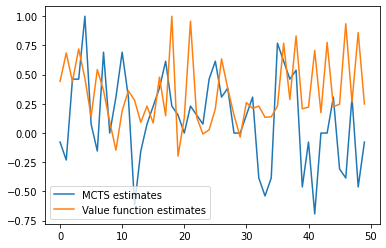

In [ ]:
mcts = [i/max(abs(est_values)) for i in est_values]
ve = model.predict_on_batch(np.array([i[0] for i in ss]))
ve -= model.predict_on_batch(np.array([-i[0] for i in ss]))
plt.plot(mcts, label="MCTS estimates")
# plt.plot([i/max(abs(est_values)) for i in old_est], label="old MCTS estimates")
# ve = np.maximum(-model.predict_on_batch(np.array([-i[0] for i in ss])), model.predict_on_batch(np.array([i[0] for i in ss])))
plt.plot(ve/max(abs(np.array(ve))), label="Value function estimates")
# plt.plot(G_V1([i[0] for i in ss])/10, label="G_V1 estimates")
plt.legend()

other models (which were not as good as the one above)

In [ ]:
def build_model():
  """
  creates a NN model for value function approximation and returns it.
  """
 
  model = keras.Sequential([
        layers.Input((16,4)),
        # layers.TimeDistributed(layers.Dense(1, activation  ="relu", name="layer1",input_shape=(16,))),
        layers.Flatten(),
        layers.Dense(64, activation  ="relu", name="layer1"),
        layers.Dropout(0.2),
        layers.Dense(32, activation  ="relu", name="layer2"),
        layers.Dropout(0.2),
        layers.Dense(16, activation  ="relu", name="layer3"),
        layers.Dropout(0.2),
        layers.Dense(8, activation  ="relu", name="layer4"),
        layers.Dropout(0.2),
        layers.Dense(4, activation  ="relu", name="layer5"),
        layers.Dense(1, activation = "linear", name="layer6"),
        ])
  # kernel_regularizer= keras.regularizers.l1_l2()
  model
  model.build()
  model.compile(loss="mse", optimizer='adam', metrics=['mae'])
  model.summary()
  plot_model(model, to_file="model1.png", show_shapes=True)
  return model

In [ ]:
def build_model():
  """
  creates a NN model for value function approximation and returns it.
  """
   
  model = keras.Sequential([
        layers.Input((16,4,1)),
        layers.Conv2D(16, kernel_size=2, activation="relu"),
        layers.Conv2D(8, kernel_size=2, activation="relu"),
        layers.Conv2D(4, kernel_size=2, activation="relu"),
        layers.Flatten(),
        layers.Dense(1, activation = "linear", name="layer6"),
        ])
  # kernel_regularizer= keras.regularizers.l1_l2()
  model
  model.build()
  model.compile(loss="mse", optimizer='adam', metrics=['mae'])
  model.summary()
  plot_model(model, to_file="model1.png", show_shapes=True)
  return model


traning the model with loaded dataset

In [ ]:
model = build_model()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
history = model.fit(np.array(dataset), np.array(labels), epochs=350, batch_size=256, validation_split=0.1, callbacks=[callback], shuffle=True)
# belos is for CNN models
# history = model.fit(np.expand_dims(dataset, axis=3), np.array(labels), batch_size=64, epochs=1, verbose=2, validation_split=0.1)

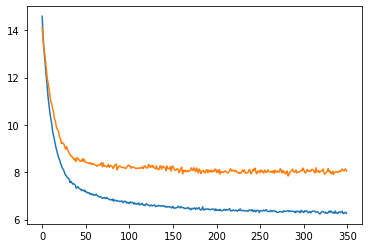

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

dataset 8 is the most complete dataset

In [ ]:
np.save('gdrive/MyDrive/RL_Project/dataset8_backup',np.array(dataset))
np.save('gdrive/MyDrive/RL_Project/labels8_backup',np.array(labels))

here you can load different datasets (with different sizes)

In [ ]:
dataset = np.load('gdrive/MyDrive/RL_Project/dataset5.npy')
labels = np.load('gdrive/MyDrive/RL_Project/labels5.npy')
print(dataset.shape, labels.shape)
# dataset = dataset.tolist()
# labels = labels.tolist()

(90002, 16, 4) (90002,)


load the most recently saved model

In [ ]:
model = keras.models.load_model('gdrive/MyDrive/RL_Project/my_model.h5')

save the current model as the most recent one

In [ ]:
keras.models.save_model(model,"drive/MyDrive/RL_Project/my_model.h5",)
